In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### import data


In [2]:
orders = pd.read_json("../raw_data/order_scoring.json",lines=True)

In [3]:
orders

,customer_id,LO,sku
0,h6IvomPZxOTKuKGuvS8b3nZrzVk2,1,1-CTR-103
1,h6IvomPZxOTKuKGuvS8b3nZrzVk2,1,2-END-103
2,h6IvomPZxOTKuKGuvS8b3nZrzVk2,1,1-LIM-136
3,h6IvomPZxOTKuKGuvS8b3nZrzVk2,1,1-ECM-114
4,h6IvomPZxOTKuKGuvS8b3nZrzVk2,1,6-VDG-101
...,...,...,...
3995333,1193650815036,4,1-PUK-109
3995334,1193650815036,4,4-LAV-105
3995335,1193650815036,4,4-ALO-102
3995336,1193650815036,4,1-PUK-104


### determining how many sku to take into consideration

In [4]:
print(len(orders['sku'].unique())," unique sku")

7503  unique sku


as we see bellow, we can take only the 1000 more orderd skus


(0.0, 6000.0)

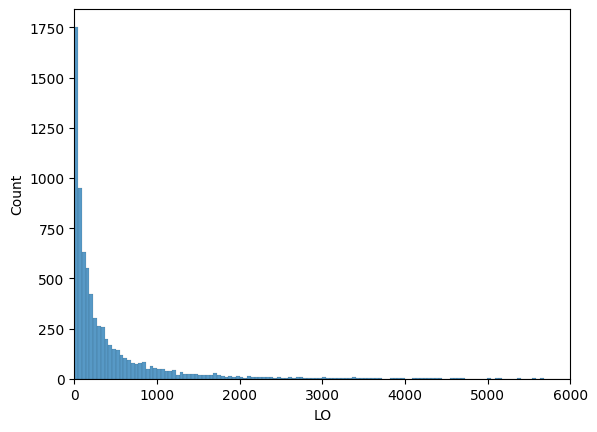

In [5]:
print("as we see bellow, we can take only the 1000 more orderd skus")
counted_sku_df = orders.groupby('sku').count()['LO'].copy()
counted_sku_df.sort_values(ascending=False,inplace=True)
sns.histplot(counted_sku_df)
plt.xlim(0,6000)


In [6]:
sku_lenght = 500

### drop unfamous skus




In [7]:
short_sku_list = list(counted_sku_df.head(sku_lenght).index)

In [8]:
orders_short = orders[orders['sku'].isin(short_sku_list)]

# Scoring

## Score each order

In [9]:
coef = {
    1:0.4,
    2:0.3,
    3:0.2,
    4:0.1
    }

In [10]:
orders_short['score'] = orders_short['LO'].map(coef)

/tmp/ipykernel_19998/1136022426.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  orders_short['score'] = orders_short['LO'].map(coef)


In [11]:
table_scoring = orders_short.groupby(by=['customer_id','sku']).sum()[['score']]

table_scoring


score
customer_id                  sku             
00HCaCqtG9aMGVCDyBUbvzIzY073 1-CNT-133    0.5
                             1-ELB-104    0.5
                             1-FAV-113    0.5
                             1-LUC-103    0.6
                             1-NTV-151    0.6
...                                       ...
zzy8Wl17TrPlHWs0QQYZyLzdUVC3 4-LAF-133    0.3
                             4-LAF-144    0.3
                             6-BRO-102    0.3
                             6-CRE-101    0.4
                             6-NAT-102    0.3

[1447552 rows x 1 columns]

## Score penality

In [12]:
penality = 0.5

In [13]:
table_penality = pd.pivot_table(orders_short, 
                       values=['score'], 
                       index=['customer_id','sku'],
                       columns=['LO'],
                       aggfunc='count',
                       fill_value=0)

table_penality['penality'] = table_penality[[('score',4),('score',3)]].max(axis=1)*(1-table_penality[('score',2)])*(1-table_penality[('score',1)])*penality
table_penality

score          penality
LO                                         1  2  3  4         
customer_id                  sku                              
00HCaCqtG9aMGVCDyBUbvzIzY073 1-CNT-133     0  1  1  0      0.0
                             1-ELB-104     0  1  1  0      0.0
                             1-FAV-113     0  1  1  0      0.0
                             1-LUC-103     0  1  1  1      0.0
                             1-NTV-151     0  1  1  1      0.0
...                                      ... .. .. ..      ...
zzy8Wl17TrPlHWs0QQYZyLzdUVC3 4-LAF-133     0  1  0  0      0.0
                             4-LAF-144     0  1  0  0      0.0
                             6-BRO-102     0  1  0  0      0.0
                             6-CRE-101     1  0  0  0      0.0
                             6-NAT-102     0  1  0  0      0.0

[1447552 rows x 5 columns]

## add those two scores

In [14]:
final_table = pd.DataFrame(table_scoring['score'] - table_penality['penality'],columns=["score"])

In [15]:
data_df = final_table.reset_index()

In [16]:
data_df

,customer_id,sku,score
0,00HCaCqtG9aMGVCDyBUbvzIzY073,1-CNT-133,0.5
1,00HCaCqtG9aMGVCDyBUbvzIzY073,1-ELB-104,0.5
2,00HCaCqtG9aMGVCDyBUbvzIzY073,1-FAV-113,0.5
3,00HCaCqtG9aMGVCDyBUbvzIzY073,1-LUC-103,0.6
4,00HCaCqtG9aMGVCDyBUbvzIzY073,1-NTV-151,0.6
...,...,...,...
1447547,zzy8Wl17TrPlHWs0QQYZyLzdUVC3,4-LAF-133,0.3
1447548,zzy8Wl17TrPlHWs0QQYZyLzdUVC3,4-LAF-144,0.3
1447549,zzy8Wl17TrPlHWs0QQYZyLzdUVC3,6-BRO-102,0.3
1447550,zzy8Wl17TrPlHWs0QQYZyLzdUVC3,6-CRE-101,0.4


### trasnpose to double entrey matrix

In [17]:
final_table

score
customer_id                  sku             
00HCaCqtG9aMGVCDyBUbvzIzY073 1-CNT-133    0.5
                             1-ELB-104    0.5
                             1-FAV-113    0.5
                             1-LUC-103    0.6
                             1-NTV-151    0.6
...                                       ...
zzy8Wl17TrPlHWs0QQYZyLzdUVC3 4-LAF-133    0.3
                             4-LAF-144    0.3
                             6-BRO-102    0.3
                             6-CRE-101    0.4
                             6-NAT-102    0.3

[1447552 rows x 1 columns]

In [18]:
matrix = pd.pivot_table(final_table, values=['score'], index=['customer_id'],
                    columns=['sku'],aggfunc='sum')


# SVD

In [19]:
all_skus = orders['sku'].unique()
all_skus
len(all_skus)

7503

### Test scikit-surprise

In [20]:
# Imports
from surprise import Reader, Dataset, SVD, NMF
from surprise.model_selection import cross_validate, train_test_split
from surprise.accuracy import rmse, mae

Exemple https://towardsdatascience.com/various-implementations-of-collaborative-filtering-100385c6dfe0

Doc scikit-surprise https://surprise.readthedocs.io/en/stable/getting_started.html#load-from-df-example

In [21]:
# On crée un Reader de scikit-surprise
reader = Reader(rating_scale=(-0.5, 1))

## SVD

In [22]:
# On crée un modèle SVD
model = SVD()

In [23]:
data_df

,customer_id,sku,score
0,00HCaCqtG9aMGVCDyBUbvzIzY073,1-CNT-133,0.5
1,00HCaCqtG9aMGVCDyBUbvzIzY073,1-ELB-104,0.5
2,00HCaCqtG9aMGVCDyBUbvzIzY073,1-FAV-113,0.5
3,00HCaCqtG9aMGVCDyBUbvzIzY073,1-LUC-103,0.6
4,00HCaCqtG9aMGVCDyBUbvzIzY073,1-NTV-151,0.6
...,...,...,...
1447547,zzy8Wl17TrPlHWs0QQYZyLzdUVC3,4-LAF-133,0.3
1447548,zzy8Wl17TrPlHWs0QQYZyLzdUVC3,4-LAF-144,0.3
1447549,zzy8Wl17TrPlHWs0QQYZyLzdUVC3,6-BRO-102,0.3
1447550,zzy8Wl17TrPlHWs0QQYZyLzdUVC3,6-CRE-101,0.4


In [24]:
data = Dataset.load_from_df(data_df, reader)

In [25]:
# J'essaie de cross-validate, pour voir le score du modèle sans aucune optimisation
cross_validate(model, data, measures=['RMSE'], cv=5, verbose=True)

KeyboardInterrupt: 

In [26]:
# On va faire un training à la main.
# On sépare train et test set
trainset, testset = train_test_split(data, test_size=0.25)


In [27]:
# On fit le model
model.fit(trainset)


In [28]:
# On fait des prédictions
predictions = model.test(testset)


In [29]:
# Résultat
rmse(predictions)


RMSE: 0.3846


0.3846067308702246

In [30]:
mae(predictions)


MAE:  0.3199


0.3199418981944055

In [31]:
# On peut faire des prédictions de score, pour un customer et un produit au hasard
# .est -> renvoie le score attendu
model.predict('h6IvomPZxOTKuKGuvS8b3nZrzVk2', '4-LAV-100')


Prediction(uid='h6IvomPZxOTKuKGuvS8b3nZrzVk2', iid='4-LAV-100', r_ui=None, est=0.15773923877754428, details={'was_impossible': False})

In [32]:
model.predict('00HCaCqtG9aMGVCDyBUbvzIzY073', '1-FAV-133')[3]


0.35753883114645557

In [33]:
# Est-ce qu'on peut prédire l'item qui aura la meilleur note ?
# Il faut appeler model.predict() sur tous les items, et choisir les meilleurs notes
CUSTOMER_ID = 'h6IvomPZxOTKuKGuvS8b3nZrzVk2'  # On choisit un customer
scores_for_customer = all_skus.copy()
scores_for_customer


array(['1-CTR-103', '2-END-103', '1-LIM-136', ..., '1-COQ-118',
       '1-SAV-115', '4-AVI-178'], dtype=object)

In [34]:
short_sku_list


['4-BOF-124',
 '3-PAP-102',
 '1-BID-121',
 '6-RIS-103',
 '1-ELB-104',
 '4-LAF-124',
 '4-GRA-105',
 '1-BID-122',
 '1-ELB-100',
 '6-BRO-102',
 '4-NTV-105',
 '6-BOF-103',
 '4-BOF-119',
 '4-CLN-112',
 '4-LAF-117',
 '6-GAB-101',
 '4-BOF-131',
 '6-BRO-101',
 '4-LAF-140',
 '4-BOF-129',
 '4-BOF-126',
 '4-BOF-133',
 '6-CAS-101',
 '1-SUC-103',
 '4-LAF-122',
 '4-BOF-125',
 '4-BOF-141',
 '4-LAF-126',
 '6-COT-105',
 '3-GRZ-103',
 '6-CAS-105',
 '6-DEA-102',
 '6-EVE-104',
 '6-SOF-104',
 '4-BOF-113',
 '6-VDG-103',
 '1-ACP-101',
 '4-LCV-104',
 '1-BID-102',
 '6-RIS-105',
 '4-BOF-132',
 '1-NTV-151',
 '1-MOM-116',
 '6-DAV-101',
 '1-SNT-103',
 '4-BOF-137',
 '6-VDG-101',
 '4-BOF-144',
 '4-COS-141',
 '6-CAS-102',
 '1-ACP-102',
 '1-BON-106',
 '1-PHL-155',
 '1-BPT-118',
 '6-LCN-102',
 '1-NTV-156',
 '6-LSD-105',
 '4-GRA-102',
 '1-SOY-112',
 '1-ATR-124',
 '1-BPT-111',
 '1-LIM-136',
 '4-NTV-104',
 '1-ECM-114',
 '6-VDG-102',
 '4-BOF-138',
 '1-NOC-102',
 '1-BPT-125',
 '6-EVE-103',
 '4-LAF-166',
 '4-BOF-134',
 '1-LU

In [ ]:
CUSTOMER_ID = 'h6IvomPZxOTKuKGuvS8b3nZrzVk2'

In [38]:
def top_items(customer_id,model,top_size=3):
    non_ordered_skus = set(short_sku_list) - set(data_df[data_df.customer_id==customer_id]['sku'])
    markdict = {sku:model.predict(customer_id, sku)[3] for sku in non_ordered_skus}
    marklist = sorted(markdict.items(), key=lambda x:x[1],reverse = True)
    return marklist[0:top_size]

In [40]:
top_items('h6IvomPZxOTKuKGuvS8b3nZrzVk2',model)

[('2-TID-103', 0.3690890019998515),
 ('2-TID-105', 0.3679092985180255),
 ('1-NTV-157', 0.3623736911464686)]